In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.linear_model import LinearRegression
import scipy.stats as sps




## Brief introduction

We are analysing the correlation between crime rate and housing prices in London boroughs, where crime rate is the independent variable, housing price is the dependent variable.

Crime has many different catagories.

$Crime\ rate = \frac{total\ crime\ in\ one\ year}{total\ population} $

Housing price used is the median price.



### Read data and cleaning

In [2]:
crime_original = pd.read_csv('MPS_Borough_Level_Crime_Historic.csv')

housing = pd.read_csv('London.Housing.csv')
#https://data.london.gov.uk/dataset/london-housing

pop_11 = pd.read_csv('census-historic-population-borough.csv',index_col=0)

__Clean housing data to only 2011.__

Originally it has 1996-2014 data, since we only have 2011 population, we clean housing data to 2011 for consistency. 

After cleaning, it contains: Borough code, borough name and median house price.

Note: converted housing price from string to float

In [3]:
housing_11 = housing.drop(housing.loc[:,'1996':'2010'],axis=1).drop(housing.loc[:,'2012':'2014'],axis=1)
housing_11.drop(housing_11.index[33:],axis=0,inplace=True)
housing_11.drop(housing_11.loc[:,'Unnamed: 21':],axis=1,inplace=True)
housing_11.rename(columns={"2011": "median housing price"},inplace=True)

In [4]:
housing_11.head()

,Code,Area,median housing price
0,E09000001,City of London,"465,000"
1,E09000002,Barking and Dagenham,"170,000"
2,E09000003,Barnet,"324,000"
3,E09000004,Bexley,"215,000"
4,E09000005,Brent,"300,000"


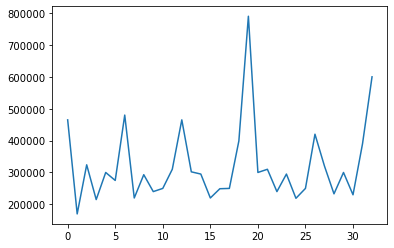

In [5]:
housing_11['median housing price']=housing_11['median housing price'].astype(str).str.replace(',','')
housing_11['median housing price'] = pd.to_numeric(housing_11['median housing price'],errors='coerce')
plt.plot(housing_11['median housing price'])

__Clean crime data to only 2011.__

Originally it has 2008-2018 data.

Cleansed data now has borough name, catogory of crime, 2011 total number of crimes. 

In [6]:
crime_original.head()

,Borough,Major Category,Minor Category,200801,200802,200803,200804,200805,200806,200807,...,201803,201804,201805,201806,201807,201808,201809,201810,201811,201812
0,Barking and Dagenham,Burglary,Burglary in a Dwelling,82,71,87,74,74,103,113,...,122,75,93,77,94,84,99,94,106,163
1,Barking and Dagenham,Burglary,Burglary in Other Buildings,59,68,56,53,57,39,44,...,61,65,39,52,40,36,50,61,60,50
2,Barking and Dagenham,Criminal Damage,Criminal Damage To Dwelling,79,52,55,73,63,80,73,...,30,29,32,29,21,29,23,35,21,15
3,Barking and Dagenham,Criminal Damage,Criminal Damage To Motor Vehicle,142,138,118,158,126,96,116,...,53,64,64,67,69,42,38,42,47,33
4,Barking and Dagenham,Criminal Damage,Criminal Damage To Other Building,20,19,20,23,16,12,17,...,6,9,8,8,7,7,11,5,4,7


In [7]:
crime_11=crime_original.drop(crime_original.loc[:,'200801':'201012'],axis=1)
crime_11.drop(crime_11.loc[:,'201201':'201812'],axis=1,inplace=True)
#crime_11.drop(crime_11.loc[:,'Minor Category'],axis=1,inplace=True)

In [8]:
crime_11.insert(len(crime_11.columns),'2011_total_crime',crime_11.loc[:,'201101':'201112'].sum(axis=1))
crime_11.drop(crime_11.loc[:,'201101':'201112'],axis=1,inplace=True)
crime_11.head()


,Borough,Major Category,Minor Category,2011_total_crime
0,Barking and Dagenham,Burglary,Burglary in a Dwelling,1625
1,Barking and Dagenham,Burglary,Burglary in Other Buildings,739
2,Barking and Dagenham,Criminal Damage,Criminal Damage To Dwelling,606
3,Barking and Dagenham,Criminal Damage,Criminal Damage To Motor Vehicle,881
4,Barking and Dagenham,Criminal Damage,Criminal Damage To Other Building,180


In [9]:
crime_11_tot = crime_11.groupby('Borough')['2011_total_crime'].sum()
crime_11_tot

Borough
Barking and Dagenham      18730
Barnet                    26393
Bexley                    12325
Brent                     31206
Bromley                   22140
Camden                    36221
Croydon                   32372
Ealing                    32879
Enfield                   23589
Greenwich                 22845
Hackney                   27666
Hammersmith and Fulham    23675
Haringey                  25357
Harrow                    14023
Havering                  17454
Hillingdon                24055
Hounslow                  24197
Islington                 27524
Kensington and Chelsea    20569
Kingston upon Thames      11089
Lambeth                   36895
Lewisham                  27916
Merton                    14461
Newham                    31910
Redbridge                 24883
Richmond upon Thames      11984
Southwark                 34850
Sutton                    11867
Tower Hamlets             29411
Waltham Forest            25756
Wandsworth                23311


Pivot table for future references

In [10]:
# crime_15_piv = pd.pivot_table(crime_15, values='2014_total', index=['Borough', 'Major Category'], aggfunc=np.sum)
# crime_15_piv

__Clean population data to 2011.__

We have 1801-2011 population census data every decade, clean it to only 2011.

In [11]:
pop_11.head()

,Persons-1801,Persons-1811,Persons-1821,Persons-1831,Persons-1841,Persons-1851,Persons-1861,Persons-1871,Persons-1881,Persons-1891,...,Persons-1921,Persons-1931,Persons-1939,Persons-1951,Persons-1961,Persons-1971,Persons-1981,Persons-1991,Persons-2001,Persons-2011
City of London,129000,121000,125000,123000,124000,128000,112000,75000,51000,38000,...,14000,11000,9000,5000,4767,4000,5864,4230,7181,7375
Barking and Dagenham,3000,4000,5000,6000,7000,8000,8000,10000,13000,19000,...,44000,138000,184000,189000,177092,161000,149786,140728,163944,185911
Barnet,8000,9000,11000,13000,14000,15000,20000,29000,41000,58000,...,147000,231000,296000,320000,318373,307000,293436,284106,314565,356386
Bexley,5000,6000,7000,9000,11000,12000,15000,22000,29000,37000,...,76000,95000,179000,205000,209893,217000,215233,211404,218301,231997
Brent,2000,2000,3000,3000,5000,5000,6000,19000,31000,65000,...,184000,251000,310000,311000,295893,281000,253275,227903,263466,311215


In [12]:
pop_11=pop_11.drop(pop_11.loc[:,'Persons-1801':'Persons-2001'],axis=1)

In [13]:
pop_11['Persons-2011']=pop_11['Persons-2011'].astype(str).str.replace(',','')
pop_11['Persons-2011'] = pd.to_numeric(pop_11['Persons-2011'],errors='coerce')

In [14]:
pop_11.head()

,Persons-2011
City of London,7375
Barking and Dagenham,185911
Barnet,356386
Bexley,231997
Brent,311215


__Join all data__

join housing price, total crime, and population. 
Calculate crime rate.
Note this definition of crime rate does not take account in the case of single person committed multiple crimes. 

In [15]:
joint= housing_11.join(crime_11_tot,how='inner',on='Area')
joint=joint.join(pop_11,how='inner',on='Area')

In [16]:
joint.insert(len(joint.columns),'crime rate', value = joint['2011_total_crime']/joint['Persons-2011'])

In [17]:
joint.head()

,Code,Area,median housing price,2011_total_crime,Persons-2011,crime rate
1,E09000002,Barking and Dagenham,170000,18730,185911,0.100747
2,E09000003,Barnet,324000,26393,356386,0.074057
3,E09000004,Bexley,215000,12325,231997,0.053126
4,E09000005,Brent,300000,31206,311215,0.100272
5,E09000006,Bromley,275000,22140,309392,0.071560


In [41]:
print(joint.Area[joint['median housing price'].idxmax()])
print(joint.Area[joint['2011_total_crime'].idxmax()])
print(joint.Area[joint['Persons-2011'].idxmax()])
print(joint.Area[joint['crime rate'].idxmax()])

Kensington and Chelsea
Westminster
Croydon
Westminster


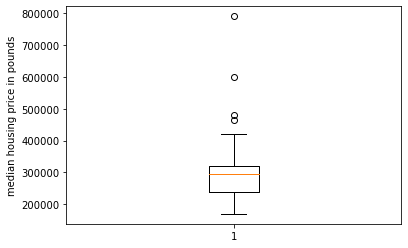

In [35]:
plt.boxplot(joint['median housing price'])
plt.ylabel('median housing price in pounds')
plt.show()

Text(0, 0.5, 'total number of crimes')

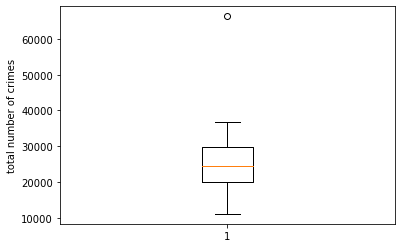

In [36]:
plt.boxplot(joint['2011_total_crime'])
plt.ylabel('total number of crimes')

Text(0, 0.5, 'population')

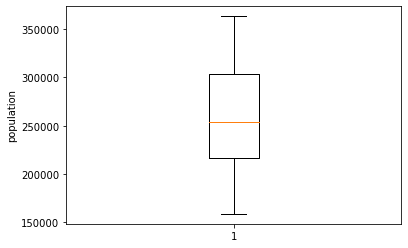

In [40]:
plt.boxplot(joint['Persons-2011'])
plt.ylabel('population')

Text(0, 0.5, 'number of crime per person')

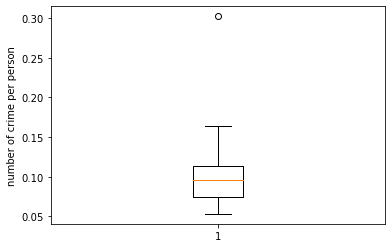

In [39]:
plt.boxplot(joint['crime rate'])
plt.ylabel('number of crime per person')

Text(0.5, 1.0, 'Each point is a borough')

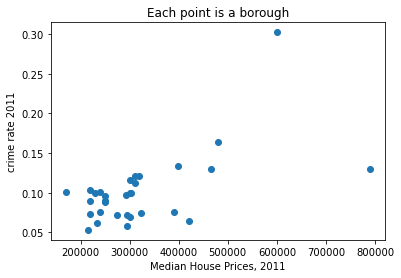

In [21]:
plt.scatter(joint['median housing price'],joint['crime rate'])
plt.xlabel('Median House Prices, 2011')
plt.ylabel('crime rate 2011')
plt.title('Each point is a borough')

polyfit Rsq =  0.3467627708623231


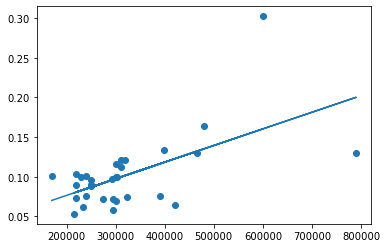

In [22]:
X,Y=joint['median housing price'],joint['crime rate']

slope, intercept, r_value, p_value, std_err = sps.linregress(X, Y) 
#f = plt.plot(X, X*slope + intercept, 'r', label = 'cases per pop line') # Plot the regression line.
f, res, _, _, _ = np.polyfit(X,Y,1, full=True)
poly = np.poly1d(f)
new_Y=poly(X)
plt.scatter(X,Y)
plt.plot(X,new_Y)

print("polyfit Rsq = ", sklearn.metrics.r2_score(Y, poly(X)))
